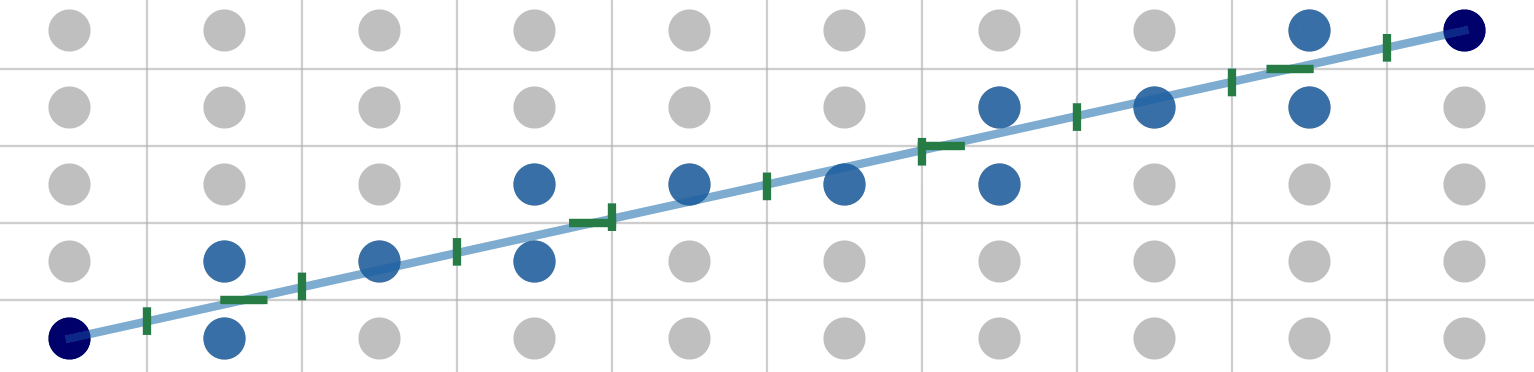

In [1]:
# Load the module
import lineint

# Helpers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# To integrate a line on a grid, I first need to define the shape of the grid
# Here I use a cube:
# size in each direction
Lx = 100
Ly = 100
Lz = 100
# number of grid points 
Nx = 64
Ny = 64
Nz = 64
# Then I can define the domain to be passed to my class
# domain = [min, max, dx]
xdomain = [-Lx/2, Lx/2, Lx/Nx]
ydomain = [-Ly/2, Ly/2, Ly/Ny]
zdomain = [-Lz/2, Lz/2, Lz/Nz]

# Next I need to define the starting point from which
# the line I am integrating along starts
starting_point = [int(Nx/4), int(Ny/4), int(Nz/4)]

# So that I can define my class
li = lineint.LineIntegrate(xdomain, ydomain, zdomain, starting_point)

Important attributes of the class:

li.igridx, li.igridy, li.igridz

representing x, y, and z np.array of the input grid, according to provided domains

li.grid0x, li.grid0y, li.grid0z

representing x, y, and z np.array of the grid having the starting position centered at (0.0, 0.0, 0.0)

# Example 1: Integrate from starting point to grid point

Text(0, 0.5, 'y')

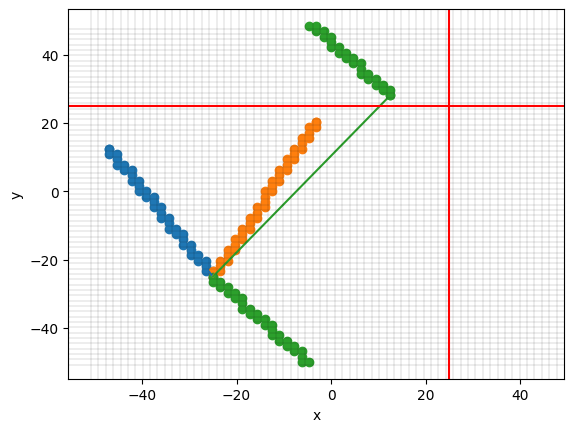

In [3]:
# Looping over multiple end grid points, to get multiple lines
end_points = [(2, 40, 16), (30, 45, 16), (40, 50, 16)]
for end_point in end_points:

    # =============== MAIN CALCULATION ===============
    # Calculate segments between start and end indices over input grid
    indices, segments, theta, phi = li.segments_idx_end(end_point)
    # ================================================

    # Plot the line to follow
    plt.plot([li.igridx[starting_point[0]], li.igridx[end_point[0]]],
             [li.igridy[starting_point[1]], li.igridy[end_point[1]]])

    # Plot the indices recorded
    ix = [i[0] for i in indices]
    iy = [i[1] for i in indices]
    plt.scatter(li.igridx[ix], li.igridy[iy])
    # The line passes through each of these grid positions.
    # They each have a corresponding segment of the line

# Grid cell boundaries
for x in li.igridx:
    plt.axvline(x=x-li.dx*0.5, color='k', linewidth=0.1)
for y in li.igridy:
    plt.axhline(y=y-li.dy*0.5, color='k', linewidth=0.1)

# Periodic boundary lines such that the starting point is in the center
plt.axvline(x=li.igridx[li.Nx - starting_point[0]], color='r')
plt.axhline(y=li.igridy[li.Ny - starting_point[1]], color='r')

# Formating
plt.xlabel('x')
plt.ylabel('y')

You can then calculate the physical distance between the points by summing over the segments, or use the segments as the weighting term of a numerical integration.

Be mindful that by design this code assumes periodic boundaries and so integrates along the shortest direction between the two grid positions. This means that half the box size is the maximum distance integrable

# Example 2: Integrate from starting point to maximum radius

Text(0, 0.5, 'y')

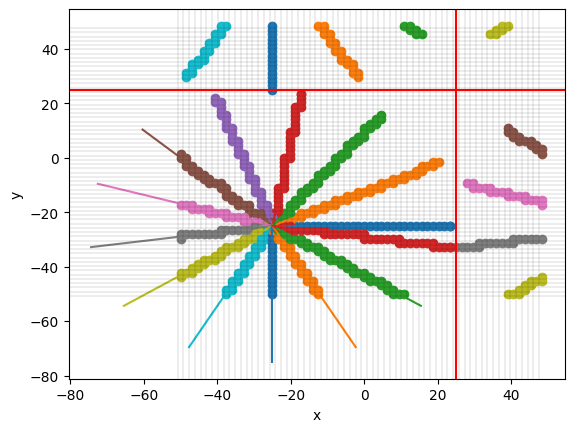

In [4]:
# Define maximum radius
maximum_radius = Lx/2 
# Lx/2 is the maximum size possible

# This needs to be provided to the class
li.maximum_radius = maximum_radius

# Looping over multiple angles on the x-y plane
theta = np.pi/2
for phi in np.arange(0, 12, 0.9):
    phi *= np.pi/6

    # =============== MAIN CALCULATION ===============
    # Calculate segments between start and maximum radius over input grid
    indices, segments = li.segments_radius_end(phi, theta)
    # ================================================

    # Plot the line to follow
    plt.plot([li.igridx[starting_point[0]], 
              maximum_radius * np.cos(phi) + li.igridx[starting_point[0]]],
             [li.igridy[starting_point[1]], 
              maximum_radius * np.sin(phi) + li.igridy[starting_point[1]]])
    
    # Plot the indices recorded
    ix = [i[0] for i in indices]
    iy = [i[1] for i in indices]
    plt.scatter(li.igridx[ix], li.igridy[iy])
    
# Grid cell boundaries
for x in li.igridx:
    plt.axvline(x=x-li.dx*0.5, color='k', linewidth=0.1)
for y in li.igridy:
    plt.axhline(y=y-li.dy*0.5, color='k', linewidth=0.1)

# Periodic boundary lines such that the starting point is in the center
plt.axvline(x=li.igridx[li.Nx - starting_point[0]], color='r')
plt.axhline(y=li.igridy[li.Ny - starting_point[1]], color='r')

# Formating
plt.xlabel('x')
plt.ylabel('y')

# Example 3: Integrate from start point to boundary condition

Import data containing a boundary condition. This boundary needs to be presented as a sign change. 

In this condition I am showing the expansion of a fluid: where it is negative the fluid is infalling/collapsing, and where it is positive it is expanding.

In [5]:
# Import data containing a boundary condition
import h5py
f = h5py.File('expansion.hdf5', 'r+')
condition = np.array(f['Theta'])
f.close()
print(np.shape(condition)) 
# check that my data grid matches that integrated upon

(64, 64, 64)


Text(0.5, 1.0, 'log( abs( condition ))')

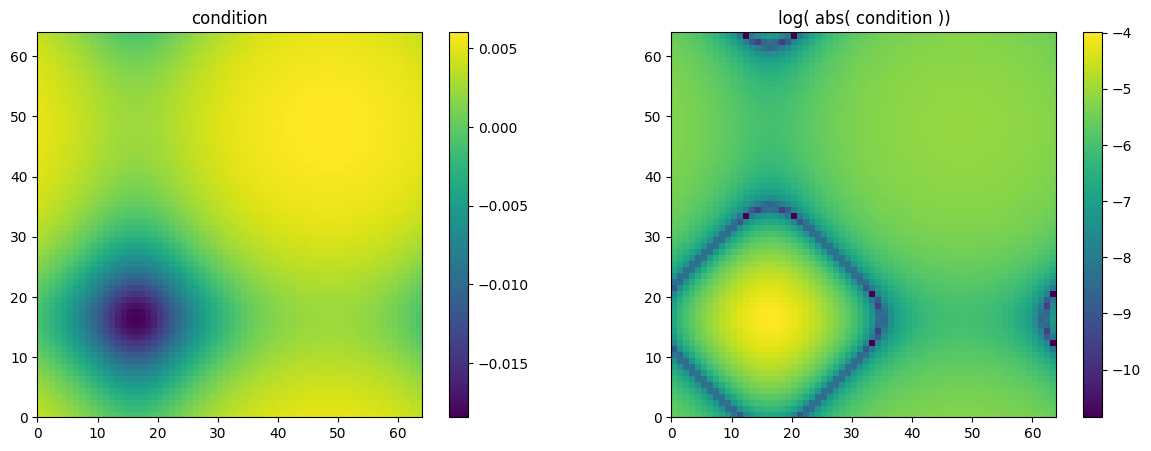

In [6]:
# Visualise the data on the x-y plane
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolor(condition[:,:,int(Nz/4)])
plt.gca().set_aspect("equal")
plt.colorbar()
plt.title('condition')

# Make the boundary condition more obvious 
plt.subplot(122)
plt.pcolor(np.log(abs(condition[:,:,int(Nz/4)])))
plt.gca().set_aspect("equal")
plt.colorbar()
plt.title('log( abs( condition ))')

To do this integration I need to shift the grid such that the starting point is in the center of the grid. The indice of the starting point was provided when the class was defined, 

starting_point = [int(Nx/4), int(Ny/4), int(Nz/4)]

so we can simply use the inbuilt shifting function.

Note that to visualise the shifted data I also changed the index on the z axis.

Text(0.5, 1.0, 'log( abs( shifted condition ))')

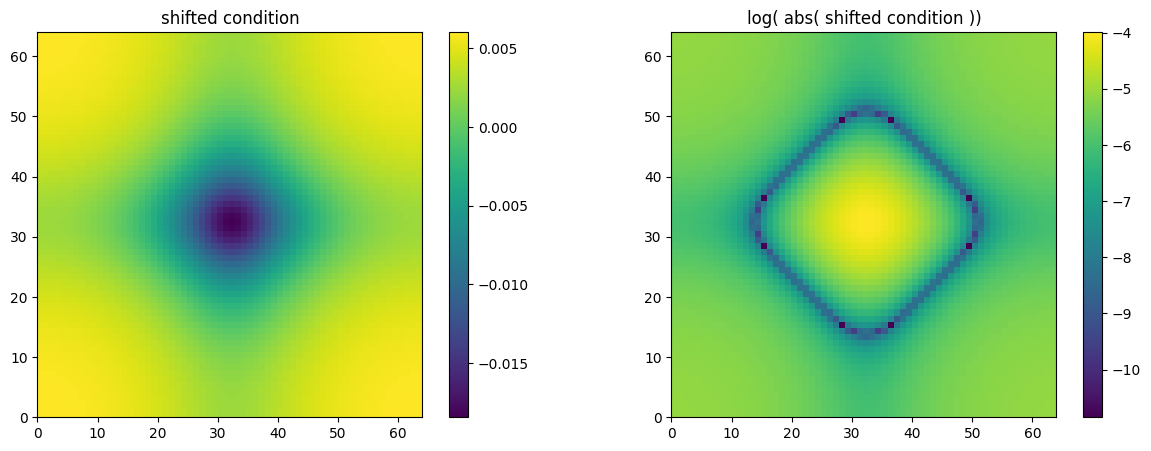

In [7]:
# Shift from the input grid 'igrid' to the ground around 0 'grid0'
condition_shifted = li.shift_igrid_to_grid0(condition)

# Visualise the data on the x-y plane
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolor(condition_shifted[:,:,int(Nz/2)])
plt.gca().set_aspect("equal")
plt.colorbar()
plt.title('shifted condition')

plt.subplot(122)
plt.pcolor(np.log(abs(condition_shifted[:,:,int(Nz/2)])))
plt.gca().set_aspect("equal")
plt.colorbar()
plt.title('log( abs( shifted condition ))')

The code will need to evaluate the condition at locations that do not match with the data grid. 
For this, either provide the function of the condition (which is the prefered option) or use scipy.interpolate.RegularGridInterpolator as a three dimensional interpolator (this is done below).
This means that the accuracy will be limited by the interpolator, you can see each method is tested in the Test notebook, and the 'cubic' method is prefered.

Note that the previous example, integrating up to a given radius, calls the function that we use below, but passes the condition's function 'radius_condition' as the condition_function.

In [8]:
# Define interpolation function of the condition
from scipy.interpolate import RegularGridInterpolator
condition_shifted_function = RegularGridInterpolator((li.grid0x, li.grid0y, li.grid0z), 
                                                     condition_shifted, method='cubic')

Text(0, 0.5, 'y')

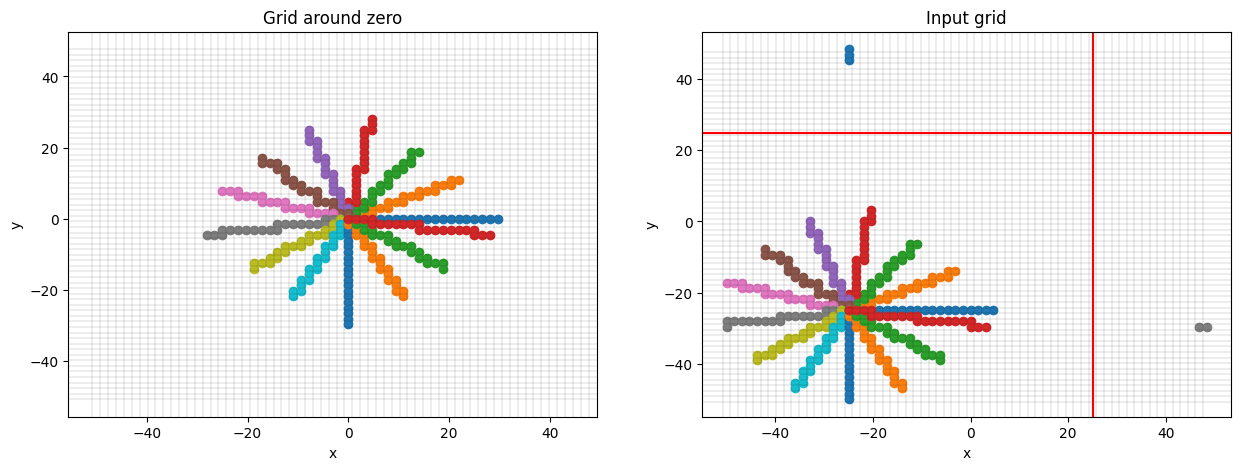

In [9]:
# Visualise
plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

# Looping over multiple angles on the x-y plane
theta = np.pi/2
for phi in np.arange(0, 12, 0.9):
    phi *= np.pi/6

    # =============== MAIN CALCULATION ===============
    # Calculate segments between start and sign change
    indices_shifted, segments = li.segments_conditional_end(phi, theta, condition_shifted, 
                                                            condition_shifted_function)
    # ================================================
    
    # Plot the indices recorded on grid around 0
    ix = [i[0] for i in indices_shifted]
    iy = [i[1] for i in indices_shifted]
    ax1.scatter(li.grid0x[ix], li.grid0y[iy])

    # Shift indices to be around starting point on input grid
    indices = [li.idx_grid0_to_igrid(idx) for idx in indices_shifted]

    # Plot the indices recorded on input grid
    ix = [i[0] for i in indices]
    iy = [i[1] for i in indices]
    ax2.scatter(li.igridx[ix], li.igridy[iy])

    
# Grid around zero cell boundaries
for x in li.grid0x:
    ax1.axvline(x=x-li.dx*0.5, color='k', linewidth=0.1)
for y in li.grid0y:
    ax1.axhline(y=y-li.dy*0.5, color='k', linewidth=0.1)
    
# Input grid cell boundaries
for x in li.igridx:
    ax2.axvline(x=x-li.dx*0.5, color='k', linewidth=0.1)
for y in li.igridy:
    ax2.axhline(y=y-li.dy*0.5, color='k', linewidth=0.1)

# Periodic boundary lines such that the starting point is in the center
ax2.axvline(x=li.igridx[li.Nx - starting_point[0]], color='r')
ax2.axhline(y=li.igridy[li.Ny - starting_point[1]], color='r')

# Formating
ax1.set_title('Grid around zero')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_title('Input grid')
ax2.set_xlabel('x')
ax2.set_ylabel('y')